In [0]:
 !pip install -U -q PyDrive ## you will have install for every colab session

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
import numpy as np
json_import = drive.CreateFile({'id':'1ONFNFcwp81mhJmTvBa-cdr9rtbh6j-NF'})
json_import.GetContentFile('y_train.npy')
y_train = np.load('y_train.npy')
json_import = drive.CreateFile({'id':'1BoBts1RcOjWrs9ZynAwW74MgEhjMREiZ'})
json_import.GetContentFile('y_test.npy')
y_test = np.load('y_test.npy')

In [42]:
y_train.shape,y_test.shape

((1599, 1), (401, 1))

In [0]:
json_import = drive.CreateFile({'id':'1xRSfGO8G25lQ_4-cANtWYkm4DbX6IV9_'})
json_import.GetContentFile('X_train.npy')
X_train = np.load('X_train.npy')
json_import = drive.CreateFile({'id':'1TmJmYnPm__-OrWOZhbSVyXW4Uzo175L8'})
json_import.GetContentFile('X_test.npy')
X_test = np.load('X_test.npy')

In [44]:
X_train.shape,X_test.shape

((1599, 128, 128, 3), (401, 128, 128, 3))

In [24]:
from google.colab import files
uploaded = files.upload()

Saving resnet_classifier_ISIC.py to resnet_classifier_ISIC.py


In [0]:
import os
import keras
from keras.models import Sequential
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D,AveragePooling2D
from keras.datasets import cifar10
from keras import regularizers, optimizers
import numpy as np
from keras.layers import Add
from keras.layers import Input
from keras.models import Model
from keras.layers import Flatten

from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix
import itertools
%matplotlib inline
from keras.callbacks import ReduceLROnPlateau, CSVLogger,EarlyStopping,ModelCheckpoint
import scipy.io as scio
import numpy as np    
import os
import matplotlib.pyplot as plt
import math
import re
from scipy.misc import imsave
from scipy.misc import imresize
from scipy import ndimage, misc
from numpy import unravel_index
from operator import sub
from keras.utils import np_utils
from keras.models import Sequential



In [0]:
x_train = X_train.astype('float32')
x_test = X_test.astype('float32')

In [0]:
mean = np.mean(x_train,axis=(0,1,2,3))
std = np.std(x_train,axis=(0,1,2,3))
x_train = (x_train-mean)/(std+1e-7)
x_test = (x_test-mean)/(std+1e-7)

In [0]:
def initial_conv(Input):
    x = Conv2D(16,kernel_size=(3,3),strides = (1,1),padding = 'same')(Input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

In [0]:

def expand_conv(Input, k=1, conv_no = 1,stride=1,dropout =0.0):
    Initial = Input
    x = Conv2D(32*k*conv_no,kernel_size=(3,3),strides = (stride,stride),padding = 'same')(Input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    if(dropout > 0):
        x = Dropout(dropout)(x)
    x = Conv2D(32*k*conv_no,kernel_size=(3,3),strides = (1,1),padding ='same')(x)
    skip = Conv2D(32*k*conv_no,kernel_size=(3,3),strides = (stride,stride),padding = 'same')(Input)
    output = Add()([x,skip])
    return output

In [0]:

def conv_block1(Input, k = 1, stride = 1, dropout = 0.0):
    Initial = Input 
    x = BatchNormalization()(Input)
    x = Activation('relu')(x)
    x = Conv2D(32*k,kernel_size=(3,3),strides = (stride,stride),padding = 'same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    if(dropout > 0.0):
        x = Dropout(dropout)(x)
    x = Conv2D(32*k,kernel_size=(3,3),strides = (stride,stride),padding = 'same')(x)
    output = Add()([x,Initial])
    return output

In [0]:

def conv_block2(Input, k = 1, stride = 1, dropout = 0.0):
    Initial = Input 
    x = BatchNormalization()(Input)
    x = Activation('relu')(x)
    x = Conv2D(64*k,kernel_size=(3,3),strides = (stride,stride),padding = 'same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    if(dropout > 0.0):
        x = Dropout(dropout)(x)
    x = Conv2D(64*k,kernel_size=(3,3),strides = (stride,stride),padding = 'same')(x)
    output = Add()([x,Initial])
    return output

In [0]:

def conv_block3(Input, k = 1, stride = 1, dropout = 0.0):
    Initial = Input 
    x = BatchNormalization()(Input)
    x = Activation('relu')(x)
    x = Conv2D(128*k,kernel_size=(3,3),strides = (stride,stride),padding = 'same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    if(dropout > 0.0):
        x = Dropout(dropout)(x)
    x = Conv2D(128*k,kernel_size=(3,3),strides = (stride,stride),padding = 'same')(x)
    output = Add()([x,Initial])
    return output

In [0]:

"""
Creates Wide Residual network with given parameters

height = height of the Image
width = width of the Image
K = Width of the network(will be multiplied)
depth = No of convolutional layers

"""
def create_wide_residual_network(height,width,k,depth):
    
    n = (depth-4)/6
    
    #Input tensor
    inputs = Input(shape = (height,width,3), name = "image_input")
    
    #Initial Conv block
    x = initial_conv(inputs)
    
    #First Expansion block
    x = expand_conv(x,k,1,1,0.3)
    
    #First Convolutional Block
    #Depth depends on n
    for i in range(n-1):
        x = conv_block1(x,k,1,0.3)
    
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    #Second Expansion Block
    x = expand_conv(x,k,2,2,0.3)
    
    
    #Second Convolutional Block
    #Depth depends on n
    for i in range(n-1):
        x = conv_block2(x,k,1,0.3)
        
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    
    #Third Expansion Block
    x = expand_conv(x,k,4,2,0.3)
    
    #Third Convolutional Block 
    #Depth depends on n
    for i in range(n-1):
        x = conv_block3(x,k,1,0.3)
    
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    #Avg pooling to get 1*1 feature vectors
    x = AveragePooling2D(pool_size=(8,8))(x)
    x = Flatten()(x)
    
    #Classification Layer
    x = Dense(1,activation="sigmoid")(x)
    
    model = Model(inputs=inputs, outputs=x)
    return model


In [0]:
model = create_wide_residual_network(128,128,4,16)


In [71]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_49 (Conv2D)              (None, 128, 128, 16) 448         image_input[0][0]                
__________________________________________________________________________________________________
batch_normalization_40 (BatchNo (None, 128, 128, 16) 64          conv2d_49[0][0]                  
__________________________________________________________________________________________________
activation_40 (Activation)      (None, 128, 128, 16) 0           batch_normalization_40[0][0]     
__________________________________________________________________________________________________
conv2d_50 

In [0]:
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)

In [0]:
model.compile(loss='binary_crossentropy',
        optimizer="Adam",
        metrics=['accuracy'])

In [0]:
lr_reducer = ReduceLROnPlateau(factor=0.5, cooldown=0, patience=6, min_lr=0.5e-6)
csv_logger = CSVLogger('classification_log.csv')
model_chekpoint = ModelCheckpoint("weights/model2",monitor = 'val_loss',verbose = 1,save_best_only=True)

In [0]:
batch_size = 32
epochs = 50

In [76]:
model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True,callbacks=[lr_reducer, csv_logger,model_chekpoint], class_weight = class_weights)

Train on 1599 samples, validate on 401 samples
Epoch 1/50
1599/1599 [==============================] - 132s 82ms/step - loss: 1.1581 - acc: 0.6854 - val_loss: 1.6028 - val_acc: 0.4364

Epoch 00001: val_loss improved from inf to 1.60280, saving model to weights/model2
Epoch 2/50
1599/1599 [==============================] - 124s 77ms/step - loss: 1.0034 - acc: 0.6854 - val_loss: 0.6705 - val_acc: 0.6434

Epoch 00002: val_loss improved from 1.60280 to 0.67045, saving model to weights/model2
Epoch 3/50
1599/1599 [==============================] - 124s 77ms/step - loss: 1.0393 - acc: 0.6548 - val_loss: 0.8656 - val_acc: 0.6683

Epoch 00003: val_loss did not improve
Epoch 4/50
1599/1599 [==============================] - 124s 77ms/step - loss: 0.9483 - acc: 0.7373 - val_loss: 0.7472 - val_acc: 0.6983

Epoch 00004: val_loss did not improve
Epoch 5/50
 128/1599 [=>............................] - ETA: 1:45 - loss: 0.8812 - acc: 0.8047

1599/1599 [==============================] - 124s 77ms/step - loss: 0.9763 - acc: 0.7405 - val_loss: 0.8533 - val_acc: 0.6010

Epoch 00005: val_loss did not improve
Epoch 6/50
1599/1599 [==============================] - 124s 77ms/step - loss: 0.9866 - acc: 0.6917 - val_loss: 0.6062 - val_acc: 0.7506

Epoch 00006: val_loss improved from 0.67045 to 0.60620, saving model to weights/model2
Epoch 7/50
1599/1599 [==============================] - 124s 77ms/step - loss: 0.9659 - acc: 0.6585 - val_loss: 0.9639 - val_acc: 0.7207

Epoch 00007: val_loss did not improve
Epoch 8/50
1599/1599 [==============================] - 124s 77ms/step - loss: 0.9324 - acc: 0.6610 - val_loss: 0.9025 - val_acc: 0.4289

Epoch 00008: val_loss did not improve
Epoch 9/50
 896/1599 [===============>..............] - ETA: 50s - loss: 0.8680 - acc: 0.7400

1599/1599 [==============================] - 124s 77ms/step - loss: 0.8650 - acc: 0.7311 - val_loss: 0.5356 - val_acc: 0.7581

Epoch 00009: val_loss improved from 0.60620 to 0.53565, saving model to weights/model2
Epoch 10/50
1599/1599 [==============================] - 124s 77ms/step - loss: 0.9015 - acc: 0.7186 - val_loss: 0.7912 - val_acc: 0.4963

Epoch 00010: val_loss did not improve
Epoch 11/50
1599/1599 [==============================] - 124s 77ms/step - loss: 1.0185 - acc: 0.7305 - val_loss: 0.7141 - val_acc: 0.7182

Epoch 00011: val_loss did not improve
Epoch 12/50
1599/1599 [==============================] - 124s 77ms/step - loss: 1.0921 - acc: 0.6929 - val_loss: 5.5778 - val_acc: 0.5137

Epoch 00012: val_loss did not improve
Epoch 13/50
 864/1599 [===============>..............] - ETA: 52s - loss: 0.9055 - acc: 0.6736

1599/1599 [==============================] - 124s 77ms/step - loss: 0.9537 - acc: 0.6760 - val_loss: 0.6362 - val_acc: 0.7107

Epoch 00013: val_loss did not improve
Epoch 14/50
1599/1599 [==============================] - 124s 77ms/step - loss: 0.8909 - acc: 0.7192 - val_loss: 0.6280 - val_acc: 0.7481

Epoch 00014: val_loss did not improve
Epoch 15/50
1599/1599 [==============================] - 124s 77ms/step - loss: 0.8914 - acc: 0.6973 - val_loss: 0.5517 - val_acc: 0.7805

Epoch 00015: val_loss did not improve
Epoch 16/50
1599/1599 [==============================] - 124s 77ms/step - loss: 0.8590 - acc: 0.7192 - val_loss: 0.6009 - val_acc: 0.6733

Epoch 00016: val_loss did not improve
Epoch 17/50
1216/1599 [=====================>........] - ETA: 27s - loss: 0.8098 - acc: 0.7393

1599/1599 [==============================] - 124s 78ms/step - loss: 0.8395 - acc: 0.7298 - val_loss: 0.6118 - val_acc: 0.6409

Epoch 00017: val_loss did not improve
Epoch 18/50
1599/1599 [==============================] - 124s 78ms/step - loss: 0.8665 - acc: 0.7430 - val_loss: 0.5692 - val_acc: 0.7406

Epoch 00018: val_loss did not improve
Epoch 19/50
1599/1599 [==============================] - 124s 78ms/step - loss: 0.8152 - acc: 0.7192 - val_loss: 0.5851 - val_acc: 0.6758

Epoch 00019: val_loss did not improve
Epoch 20/50
1599/1599 [==============================] - 124s 78ms/step - loss: 0.8215 - acc: 0.7273 - val_loss: 0.5838 - val_acc: 0.6608

Epoch 00020: val_loss did not improve
Epoch 21/50
1248/1599 [======================>.......] - ETA: 25s - loss: 0.8353 - acc: 0.7131

1599/1599 [==============================] - 124s 77ms/step - loss: 0.8159 - acc: 0.7255 - val_loss: 0.5565 - val_acc: 0.7357

Epoch 00021: val_loss did not improve
Epoch 22/50
1599/1599 [==============================] - 124s 78ms/step - loss: 0.8373 - acc: 0.7292 - val_loss: 0.5472 - val_acc: 0.7282

Epoch 00022: val_loss did not improve
Epoch 23/50
1599/1599 [==============================] - 124s 78ms/step - loss: 0.8229 - acc: 0.7336 - val_loss: 0.5418 - val_acc: 0.7431

Epoch 00023: val_loss did not improve
Epoch 24/50
1599/1599 [==============================] - 124s 77ms/step - loss: 0.8092 - acc: 0.7330 - val_loss: 0.5397 - val_acc: 0.7282

Epoch 00024: val_loss did not improve
Epoch 25/50
1248/1599 [======================>.......] - ETA: 25s - loss: 0.8019 - acc: 0.7444

1599/1599 [==============================] - 124s 77ms/step - loss: 0.7940 - acc: 0.7405 - val_loss: 0.5580 - val_acc: 0.7032

Epoch 00025: val_loss did not improve
Epoch 26/50
1599/1599 [==============================] - 124s 77ms/step - loss: 0.7870 - acc: 0.7624 - val_loss: 0.5606 - val_acc: 0.6833

Epoch 00026: val_loss did not improve
Epoch 27/50
1599/1599 [==============================] - 124s 77ms/step - loss: 0.7828 - acc: 0.7361 - val_loss: 0.6082 - val_acc: 0.6409

Epoch 00027: val_loss did not improve
Epoch 28/50
1599/1599 [==============================] - 124s 77ms/step - loss: 0.7925 - acc: 0.7536 - val_loss: 0.5406 - val_acc: 0.7182

Epoch 00028: val_loss did not improve
Epoch 29/50
1248/1599 [======================>.......] - ETA: 25s - loss: 0.7524 - acc: 0.7644

1599/1599 [==============================] - 124s 78ms/step - loss: 0.7775 - acc: 0.7661 - val_loss: 0.5680 - val_acc: 0.6833

Epoch 00029: val_loss did not improve
Epoch 30/50
1599/1599 [==============================] - 124s 78ms/step - loss: 0.7491 - acc: 0.7605 - val_loss: 0.5370 - val_acc: 0.7332

Epoch 00030: val_loss did not improve
Epoch 31/50
1599/1599 [==============================] - 124s 78ms/step - loss: 0.7605 - acc: 0.7567 - val_loss: 0.5348 - val_acc: 0.7481

Epoch 00031: val_loss improved from 0.53565 to 0.53477, saving model to weights/model2
Epoch 32/50
1599/1599 [==============================] - 124s 78ms/step - loss: 0.7465 - acc: 0.7736 - val_loss: 0.5607 - val_acc: 0.7082

Epoch 00032: val_loss did not improve
Epoch 33/50
1056/1599 [==================>...........] - ETA: 38s - loss: 0.7231 - acc: 0.7547

1599/1599 [==============================] - 124s 78ms/step - loss: 0.7403 - acc: 0.7592 - val_loss: 0.5732 - val_acc: 0.6933

Epoch 00033: val_loss did not improve
Epoch 34/50
1599/1599 [==============================] - 124s 78ms/step - loss: 0.7428 - acc: 0.7611 - val_loss: 0.5817 - val_acc: 0.6858

Epoch 00034: val_loss did not improve
Epoch 35/50
1599/1599 [==============================] - 124s 78ms/step - loss: 0.7328 - acc: 0.7817 - val_loss: 0.5495 - val_acc: 0.7082

Epoch 00035: val_loss did not improve
Epoch 36/50
1599/1599 [==============================] - 124s 78ms/step - loss: 0.7243 - acc: 0.7742 - val_loss: 0.5517 - val_acc: 0.7057

Epoch 00036: val_loss did not improve
Epoch 37/50
1248/1599 [======================>.......] - ETA: 25s - loss: 0.7156 - acc: 0.7780

1599/1599 [==============================] - 124s 78ms/step - loss: 0.7333 - acc: 0.7598 - val_loss: 0.5311 - val_acc: 0.7481

Epoch 00037: val_loss improved from 0.53477 to 0.53105, saving model to weights/model2
Epoch 38/50
1599/1599 [==============================] - 124s 78ms/step - loss: 0.7232 - acc: 0.7755 - val_loss: 0.5159 - val_acc: 0.7431

Epoch 00038: val_loss improved from 0.53105 to 0.51589, saving model to weights/model2
Epoch 39/50
1599/1599 [==============================] - 124s 78ms/step - loss: 0.7242 - acc: 0.7742 - val_loss: 0.5638 - val_acc: 0.6833

Epoch 00039: val_loss did not improve
Epoch 40/50
1599/1599 [==============================] - 124s 78ms/step - loss: 0.6941 - acc: 0.7986 - val_loss: 0.5671 - val_acc: 0.6883

Epoch 00040: val_loss did not improve
Epoch 41/50
 640/1599 [===========>..................] - ETA: 1:08 - loss: 0.7334 - acc: 0.7781

1599/1599 [==============================] - 124s 78ms/step - loss: 0.7169 - acc: 0.7780 - val_loss: 0.5613 - val_acc: 0.6983

Epoch 00041: val_loss did not improve
Epoch 42/50
1599/1599 [==============================] - 124s 78ms/step - loss: 0.7071 - acc: 0.7861 - val_loss: 0.5750 - val_acc: 0.7057

Epoch 00042: val_loss did not improve
Epoch 43/50
1599/1599 [==============================] - 124s 78ms/step - loss: 0.6982 - acc: 0.7824 - val_loss: 0.5987 - val_acc: 0.6733

Epoch 00043: val_loss did not improve
Epoch 44/50
1599/1599 [==============================] - 124s 78ms/step - loss: 0.6892 - acc: 0.7855 - val_loss: 0.5743 - val_acc: 0.6683

Epoch 00044: val_loss did not improve
Epoch 45/50
1216/1599 [=====================>........] - ETA: 27s - loss: 0.6928 - acc: 0.7887

1599/1599 [==============================] - 124s 78ms/step - loss: 0.6858 - acc: 0.7980 - val_loss: 0.5610 - val_acc: 0.6933

Epoch 00045: val_loss did not improve
Epoch 46/50
1599/1599 [==============================] - 124s 78ms/step - loss: 0.6504 - acc: 0.8005 - val_loss: 0.5712 - val_acc: 0.6808

Epoch 00046: val_loss did not improve
Epoch 47/50
1599/1599 [==============================] - 124s 78ms/step - loss: 0.6408 - acc: 0.8074 - val_loss: 0.5283 - val_acc: 0.7232

Epoch 00047: val_loss did not improve
Epoch 48/50
1599/1599 [==============================] - 124s 78ms/step - loss: 0.6509 - acc: 0.8143 - val_loss: 0.5464 - val_acc: 0.7132

Epoch 00048: val_loss did not improve
Epoch 49/50
1248/1599 [======================>.......] - ETA: 25s - loss: 0.5989 - acc: 0.8197

1599/1599 [==============================] - 124s 78ms/step - loss: 0.6303 - acc: 0.8043 - val_loss: 0.5781 - val_acc: 0.6783

Epoch 00049: val_loss did not improve
Epoch 50/50
1599/1599 [==============================] - 124s 78ms/step - loss: 0.6275 - acc: 0.8099 - val_loss: 0.5641 - val_acc: 0.6958

Epoch 00050: val_loss did not improve


In [0]:
model.load_weights('weights/model2.h5')

In [0]:
predictions = model.predict(x_test)

In [0]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,name = "Cf.png",
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    fig = plt.gcf()
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    fig.savefig(name)
    plt.show()

Confusion matrix, without normalization
[[195 131]
 [ 33  42]]


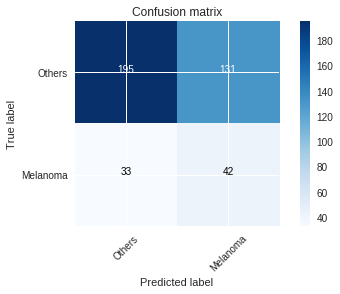

In [106]:
class_names = ['Others', 'Melanoma']
predictions = np.array(predictions)
predictions_results = predictions >= 0.5
cnf_matrix = confusion_matrix(y_test, predictions_results)
plot_confusion_matrix(cnf_matrix, classes=class_names,normalize= False,
                      name = "Confusion_matrix.png",
                      title='Confusion matrix')